In [3]:
import io

import networkx as nx
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.geometry

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
network_url = 'https://zenodo.org/record/4578289/files/network_digital_twin_v0.2.pickle?download=1'
velocities_path = 'velocities/velocities.json'

# Read the input
We have two input files. The velocity geojson dataset with multiple features, one feature per scenario.  We also have the current version of the digital twin network. We will read the velocities as a geodataframe. We will read the network as a graph.

In [5]:
resp = requests.get(network_url)
stream = io.BytesIO(resp.content)
G = nx.read_gpickle(stream)

In [6]:
velocities_df = gpd.read_file(velocities_path)
# convert to tuples, do not do this with untrusted data
velocities_df['id'] = velocities_df['id'].apply(eval)
velocities_df = velocities_df.set_index('id')
velocities_df.head()


,scenario,velocity,geometry
id,,,
"(22638188, 8861687)",Q1020,0.810,"LINESTRING (5.83404 51.86192, 5.83355 51.86220..."
"(22638200, 28197686)",Q1020,0.795,"LINESTRING (6.08125 51.85749, 6.07880 51.85877..."
"(28197686, 8863233)",Q1020,0.770,"LINESTRING (6.06350 51.86545, 6.05740 51.86753..."
"(28197693, 8862687)",Q1020,0.948,"LINESTRING (6.16655 51.84093, 6.16336 51.84184..."
"(8860617, 8865603)",Q1020,0.020,"LINESTRING (4.96659 51.95968, 4.96592 51.95962..."


# Check network
Compare the velocity edges with the full network. 

In [7]:
# check that all edges are pressent
edges = [G.edges[idx] for idx in velocities_df.index]

In [8]:
# list all nodes in the velocities data frame
nodes = []
for e in velocities_df.index:
    nodes.extend(e)
nodes = set(nodes)

# create a subgraph of only the data with velocities
G_velocities = G.subgraph(nodes)    

3

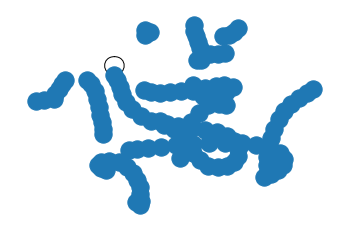

In [9]:
# this should show some gaps
fig, ax = plt.subplots()
nx.draw(G_velocities, ax=ax)
# count the number of cliques, even without cliques some edges maybe missing
nx.clique.graph_clique_number(G)

# Find edges without velocities
We can use several approaches for the missing edges. We could loop over edges of main routes and remember the last velocity and the next velocity and fill it in. Here we are looking from the edges that are missing. From those missing edges we will search left and right until we have 2 velocities. 

We will first define the boundary nodes of the routes where we expect edges to be filled with velocities. 

In [10]:
boundary_nodes = {
    "slikkerveer": "8865140",
    "werkendam": '22638029',
    "emmerich": '8861160',
    "ketelhaven": '8863596'
}


Now determine the routes, based on the boundary nodes, by finding the shortest paths.

In [11]:
# origin destination diagrams
ods = [
    [boundary_nodes['slikkerveer'], boundary_nodes['emmerich']],
    [boundary_nodes['werkendam'], boundary_nodes['emmerich']],
    [boundary_nodes['ketelhaven'], boundary_nodes['emmerich']]
]

Based on these origin destination paths, keep track of all the nodes

In [12]:
# lookup all nodes that are in one of our routes of interest
od_paths = []
for od in ods:
    od_path = nx.shortest_path(G, od[0], od[1])
    od_paths.extend(od_path)

Now we can create a new subgraph with only the nodes that we are interested in.

In [13]:
G_boundaries = G.subgraph(od_paths)

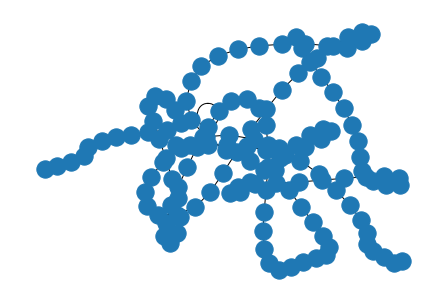

In [14]:
nx.draw(G_boundaries)

In [15]:
# Compute the positions to render for the graph
pos = {}
for n in G_boundaries.nodes:
    node = G_boundaries.nodes[n]
    pos[n] = (node['X'], node['Y'])

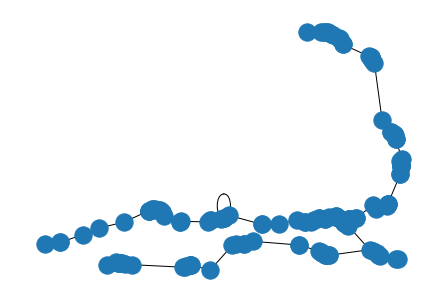

In [16]:
# plot the subgraph with only the relevant parts
nx.draw(G_boundaries, pos)

# Search missing edges
Now that we know which edges we want velocities. We can lookup the ones that we have velocities. The ones remaining are the missings. 

We use `e` to refer to an edge id (tuple of node ids) and `e_r` as the reversed version of that edge id. 

In [17]:
missing_edges = []
for e in G_boundaries.edges:
    edge = G_boundaries.edges[e]
    e_r = tuple(reversed(e))
    
    # is e in our list of ids
    has_e = e in velocities_df.index
    # is e reversed in our list
    has_e_r = e_r in velocities_df.index
    # either one, we already have a velocity
    if has_e or has_e_r:
        continue
        
    # if we did not find our edge it is missing and needs interpolation
    missing_edges.append(e)

In [18]:
# how many edges are we missing
len(missing_edges)

57

In [19]:
# print one example
missing_edge = missing_edges[0]
missing_edge

('L10232_B', 'L10232_A')

# Depth first search back and forth
Now for the main logic. Look left down the graph, using depth first predessors. Look right down the graph, using successors. Keep track of the velocities that we find.

In [20]:
def find_velocities(missing_edge):
    """find nearest velocities left and right of this edge"""
    
    left_velocity = None
    prev_n = missing_edge[0]
    for n in nx.dfs_predecessors(G, missing_edge[0]):

        # edge
        e = (prev_n, n)

        # reversed edge
        e_r = (n, prev_n)

        # do we have a velocity in this edge
        has_e = e in velocities_df.index
        if has_e:
            # use a list of 1 tuple so it does not think it should unpack it
            left_velocity = velocities_df.loc[[e]]
            break
        
        has_e_r = e_r in velocities_df.index
        if has_e_r:
            # use a list of 1 tuple so it does not think it should unpack it

            left_velocity = velocities_df.loc[[e_r]]
            break
        prev_n = n
        
        
    right_velocity = None
    prev_n = missing_edge[1]
    for n in nx.dfs_successors(G, missing_edge[1]):

        # edge
        e = (prev_n, n)

        # reversed edge
        e_r = (n, prev_n)

        # do we have a velocity in this edge
        has_e = e in velocities_df.index
        if has_e:
            # use a list of 1 tuple so it does not think it should unpack it
            right_velocity = velocities_df.loc[[e]]
            break
        
        has_e_r = e_r in velocities_df.index
        if has_e_r:
            # use a list of 1 tuple so it does not think it should unpack it

            right_velocity = velocities_df.loc[[e_r]]
            break
        prev_n = n
        

    return left_velocity, right_velocity



# Merge datasets and interpolate
Here we lookup the left and right branch velocities.

In [21]:
missing_dfs = []
for missing_edge in missing_edges:
    left_velocities, right_velocities = find_velocities(missing_edge)
    # merge left and right dataframe (by scenario)
    interpolate_df = pd.merge(
        left_velocities.reset_index(), 
        right_velocities.reset_index(), 
        left_on='scenario', 
        right_on='scenario',
        suffixes=['_left', '_right']
    )
    # add edge id
    interpolate_df['id'] = [missing_edge for i in range(interpolate_df.shape[0])]
    # compute average velocity per scenario
    interpolate_df['velocity'] = (interpolate_df['velocity_left'] + interpolate_df['velocity_right']) / 2
    # lookup our geometry
    geometry = G.edges[missing_edge]['geometry']
    # convert it to shapely object
    geometry = shapely.geometry.asShape(geometry)
    # add it to all rows
    interpolate_df['geometry'] = [geometry for i in range(interpolate_df.shape[0])]
    # append to the list
    missing_dfs.append(
        interpolate_df[['id', 'scenario', 'geometry', 'velocity']]
    )

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.asShape(geometry)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/shapely/geometry/linestring.py:211: ShapelyDeprecationWarning: The 'array_interface' method is deprecated and will be removed in Shapely 2.0.
  return self.array_interface()
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.a

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.asShape(geometry)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/shapely/geometry/linestring.py:211: ShapelyDeprecationWarning: The 'array_interface' method is deprecated and will be removed in Shapely 2.0.
  return self.array_interface()
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.a

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.asShape(geometry)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/shapely/geometry/linestring.py:211: ShapelyDeprecationWarning: The 'array_interface' method is deprecated and will be removed in Shapely 2.0.
  return self.array_interface()
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.a

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.asShape(geometry)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/shapely/geometry/linestring.py:211: ShapelyDeprecationWarning: The 'array_interface' method is deprecated and will be removed in Shapely 2.0.
  return self.array_interface()
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_55881/3936496931.py:19: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  geometry = shapely.geometry.a

In [22]:
# merge all dataframes
velocities_interpolated_df = pd.concat(
    missing_dfs + [velocities_df.reset_index()]
).set_index('id')

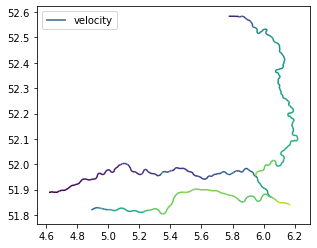

In [23]:
# check if it looks good...
velocities_interpolated_df.query("scenario == 'Q2000'").plot(column='velocity', label='velocity')
plt.legend(loc='upper left')